# The Anatomy of a mewithoutYou Setlist
Exploring mewithoutYou's 2018-2019 [Untitled] Tour

## Standard Analysis Setup

In [1]:
# Standard imports to run concert_analytics

import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname(""), "../../"))
sys.path.insert(0, PROJECT_ROOT)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from postgres import fetch_table,run_query

import logging

logging.basicConfig(level=logging.INFO)  # DEBUG < INFO < WARNING < ERROR < CRITICAL

pd.set_option("display.max_columns", None)  # Show all columns

from plotnine import theme, element_text, element_blank, element_rect, element_line

# def rrg_theme(base_family_axis="Courier New", base_family_title="Helvetica"):
#     return (
#         theme(
#             # Backgrounds
#             plot_background=element_rect(fill="#FAF3E0", color=None),
#             panel_background=element_rect(fill="#FAF3E0", color=None),
#             panel_border=element_blank(),

#             # Margins around the entire plot
#             plot_margin_top= .0015, 
#             plot_margin_right=.0015,
#             plot_margin_bottom=.0015, 
#             plot_margin_left=.0015, 

#             # Titles & subtitles
#             plot_title=element_text(
#                 family=base_family_title,
#                 size=20,
#                 weight='bold',
#                 color='#1c1c1c',
#                 ha='left',
#                 margin={'b': 10}  # spacing below title
#             ),
#             plot_subtitle=element_text(
#                 family=base_family_title,
#                 size=14,
#                 color='#777777',
#                 ha='left',
#                 margin={'b': 12}  # spacing below subtitle
#             ),
#             plot_caption=element_text(
#                 family=base_family_axis,
#                 size=10,
#                 color='#777777',
#                 ha='right',
#                 margin={'t': 10}  # spacing above caption
#             ),

#             # Axis
#             axis_title=element_text(
#                 family=base_family_axis,
#                 size=10,
#                 color='#777777',
#                 weight='normal',
#                 margin={'t': 5, 'r': 5}  # tweak based on axis
#             ),
#             axis_text=element_text(
#                 family=base_family_axis,
#                 size=10,
#                 color='#1c1c1c'
#             ),
#             axis_ticks=element_line(color="#777777"),
#             axis_ticks_minor=element_blank(),
#             panel_grid_major=element_blank(),
#             panel_grid_minor=element_blank(),

#             # Legend
#             legend_title=element_blank(),
#             legend_background=element_blank(),
#             legend_key=element_blank(),
#             legend_margin=margins(t=5, b=5),
#             legend_box_margin=margins(t=10)
#         )
#     )

album_colors = {
    '[Untitled]': '#264653',
    '[A→B] Life': '#2a9d8f',
    'Catch for Us the Foxes': '#e9c46a',
    'Brother, Sister': '#f4a261',
    'It’s All Crazy...': '#e76f51',
    'Ten Stories': '#8d99ae',
    'Pale Horses': '#6a4c93'
}

## Fetch our dataset

In [4]:
# fetch setlist and spotify metadata

query="""
with track_link_cte as (
	select 
 		sim.event_set_song_id
 		,sim.track_id
 		,row_number() over (partition by sim.event_set_song_id order by similarity_score desc nulls last) as similarity_rank_post_filter
	 from 
	 	analytics_mart.mart_track_setlist_similarity_scores as sim 
	 	join analytics_mart.mart_all_tracks as all_tr
	 		on sim.track_id = all_tr.track_id
	 where true
	 	and all_tr.album_id not in ('4bGIhBIGsziCakPziupVmQ','39P5R1B5XF1dGhpojrukVA','06y12naBReESEe7u2OFG7j')
)
, track_link_filtered_cte as (
	select 
 		*
	 from 
	 	track_link_cte
	 where true
	 	and similarity_rank_post_filter = 1
)
select 
	msh.*
	,tr.*
from 
	analytics_mart.mart_setlist_history as msh
	left join track_link_filtered_cte as tl_cte
		on msh.event_set_song_id = tl_cte.event_set_song_id
	left join analytics_mart.mart_all_tracks as tr
		on tl_cte.track_id = tr.track_id
where true
    and msh.event_tour_id = 'dff91b2e201d2bfdb4f7a16b57c62194'
    and msh.event_date <= '2019-01-01'
"""

df = run_query(query)

## How many songs per night?

/Users/nahumgarcia/Reservoir/ReservoirResearchGroup/concert-analytics/.venv/lib/python3.13/site-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


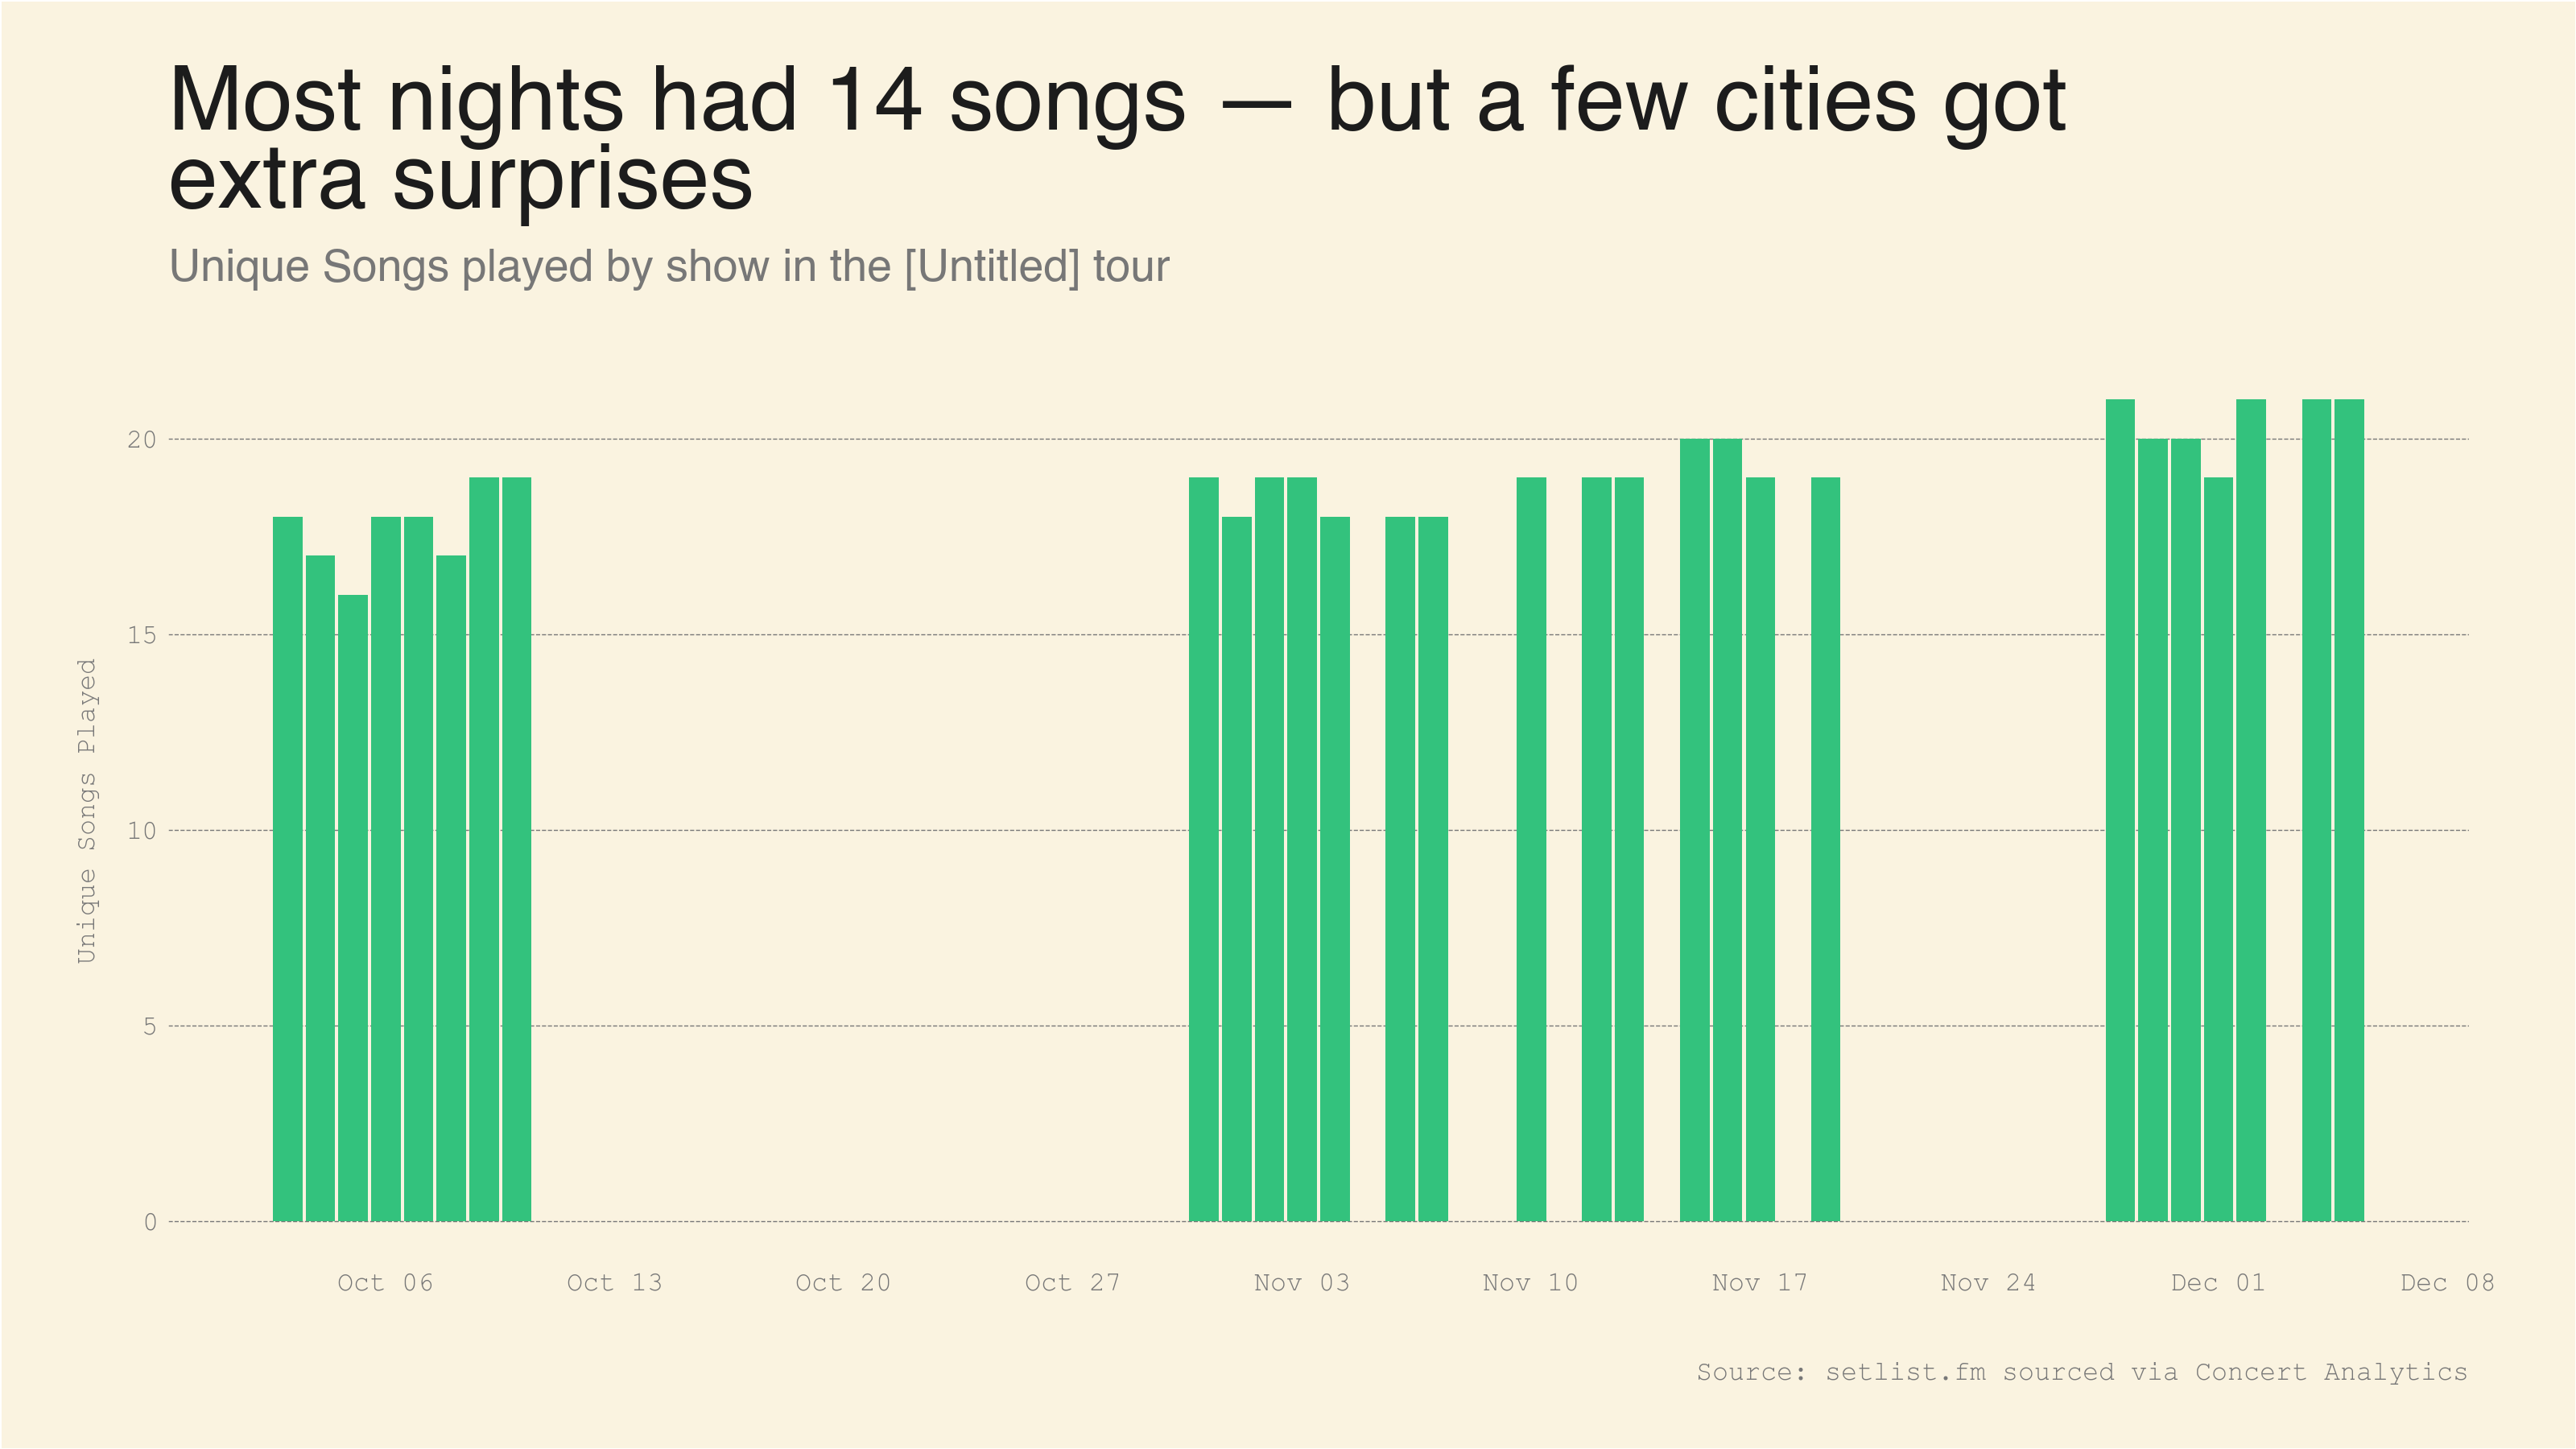

In [6]:
# songs_per_night = 
songs_per_night = (
    df.groupby('event_date')['event_set_song_id']
    .nunique()
    .reset_index(name='unique_song_count')
    .sort_values('event_date')
)

from plotnine import ggplot, aes, geom_col, labs, theme, element_text, element_rect, scale_x_datetime

base_family_axis="Courier New"
base_family_title="Helvetica"

# Build the plot
g = (
    ggplot(songs_per_night, aes(x='event_date', y='unique_song_count')) +
    geom_col(fill='#33C27D') +
    scale_x_datetime(date_labels="%b %d", date_breaks="1 week") +
    labs(
        title="Most nights had 14 songs — but a few cities got \nextra surprises",
        subtitle="Unique Songs played by show in the [Untitled] tour",
        y="Unique Songs Played",
        caption="Source: setlist.fm sourced via Concert Analytics"
    ) +
    theme(
        # aspect_ratio = 9 / 16
        # , 
        figure_size=(16,9)
        
        # Backgrounds
        , plot_background=element_rect(fill="#FAF3E0", color=None)
        , panel_background=element_rect(fill="#FAF3E0", color=None)
        , panel_border=element_blank()

        #Margins
        ,plot_margin_top= .025
        ,plot_margin_bottom=.025
        ,plot_margin_right= 0.03
        ,plot_margin_left=0.03

        # Titles & subtitles
        ,plot_title=element_text(
            family=base_family_title
            ,size=40
            ,weight='bold'
            ,color='#1c1c1c'
            ,ha='left'
            ,margin={'b': 10}  # spacing below title
        )

        , plot_subtitle=element_text(
            family=base_family_title
            ,size=20
            ,color='#777777'
            ,ha='left'
            ,margin={'b': 30}  # spacing below subtitle
        )
        
        , plot_caption=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,ha='right'
            ,margin={'t': 30}  # spacing above caption
        )

        # Axis
        ,axis_title=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,weight='ultralight'
            # ,margin={'t': 5, 'r': 5}  # tweak based on axis
        )
        
        ,axis_text=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            # ,margin={'l':5, 't':20}
        )

        ,axis_title_x=element_blank()
        
        ,axis_ticks=element_line(
            color="#FAF3E0"
        )
        ,panel_grid_major_y = element_line(
            color="#777777"
            ,linetype="dashed"
            ,size=.5
        )

        ,axis_ticks_minor=element_blank()
        ,panel_grid_major_x =element_blank()
        ,panel_grid_minor=element_blank()

        # # Legend
        # ,legend_title=element_blank()
        # ,legend_background=element_blank()
        # ,legend_key=element_blank()
        # ,legend_margin=margins(t=5, b=5)
        # ,legend_box_margin=margins(t=10)

    
    )
)

g

## How Many Unique Songs were Played in Total?

In [ ]:
def preview_palette(color_dict):
    fig, ax = plt.subplots(figsize=(8, 1))
    for i, (label, color) in enumerate(color_dict.items()):
        ax.bar(i, 1, color=color)
        ax.text(i, -0.3, label, ha='center', fontsize=10, rotation=45)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.5, len(color_dict)-0.5)
    ax.set_title("Custom Album Color Palette")
    plt.show()

preview_palette(album_colors)

In [ ]:
# songs_per_night = 
songs_albums = (
    df.groupby(['track_name','album_name'])['event_set_song_id']
    .nunique()
    .reset_index(name="times_played")
    .sort_values('times_played')
    .reset_index(drop=True)
)

songs_albums

# Set up the figure
plt.figure(figsize=(16, 24))

# Create color palette based on albums
album_colors = {
    "A To B Life": "#A7ECF5",
    "Brother, Sister": "#5D4E8C",
    "Catch For Us The Foxes": "#3C7DC4",
    "It's All Crazy! It's All False! It's All A Dream! It's Alright": "#D64848",
    "Pale Horses": "#F25C05",
    "Pale Horses: Appendix":"#F1FF72",
    "Ten Stories": "#8E508D",
    "[Untitled]": "#33C27D",
    "[untitled] e.p.": "#F6DA89"
}

# Plot each bar with color by album
bar_colors = songs_albums['album_name'].map(album_colors)
plt.barh(
    songs_albums['track_name'],
    songs_albums['times_played'],
    color=bar_colors
)

# Labels and title
plt.xlabel("Number of Times Played")
plt.ylabel("Song")
plt.title("Song Frequency on the mewithoutYou [Untitled] Tour")
plt.tight_layout()

# Add legend for albums
from matplotlib.patches import Patch
legend_patches = [Patch(color=color, label=album) for album, color in album_colors.items()]
plt.legend(handles=legend_patches, title='Album', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
# unique songs per album

# Count how many unique songs from each album were played
unique_songs_by_album = (
    songs_albums.groupby('album_name')['track_name']
    .nunique()
    .reset_index(name='unique_song_count')
    .sort_values('unique_song_count', ascending=False)
)


# Setup
plt.figure(figsize=(12, 8))

# Base bar (total unique songs)
plt.barh(
    ['Unique Songs Played'],
    [unique_songs_by_album['unique_song_count'].sum()],
    color='lightgray'
)

# Stack segments
left = 0
for _, row in unique_songs_by_album.iterrows():
    width = row['unique_song_count']
    album = row['album_name']
    color = album_colors[album]
    
    plt.barh(
        ['Unique Songs Played'],
        [width],
        left=left,
        color=color
    )
    left += width

# Labels
plt.xlabel("Number of Unique Songs")
plt.title("Unique Songs Played per Album on the [Untitled] Tour")

# Bottom legend
legend_patches = [Patch(color=color, label=album) for album, color in album_colors.items()]
plt.legend(
    handles=legend_patches,
    title='Album',
    loc='lower center',
    bbox_to_anchor=(0.5, -0.5),
    ncol=3,  # tweak this depending on how many albums you have
    frameon=False
)

plt.tight_layout()
plt.show()

In [ ]:
## Most Commonly Played Songs

In [ ]:
## Openers and Closers

In [ ]:
## Rarest Songs

In [ ]:
## Album Representation per Show

In [ ]:
## How popularity moves within a set

In [ ]:
## City that got the worst or best set list

In [ ]:
## How popularity moved for the tour (avg. Popularity per show)